# Time Series Forecasting on Harga Pangan Indonesia

### Import Package

In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt

### Load Dataset

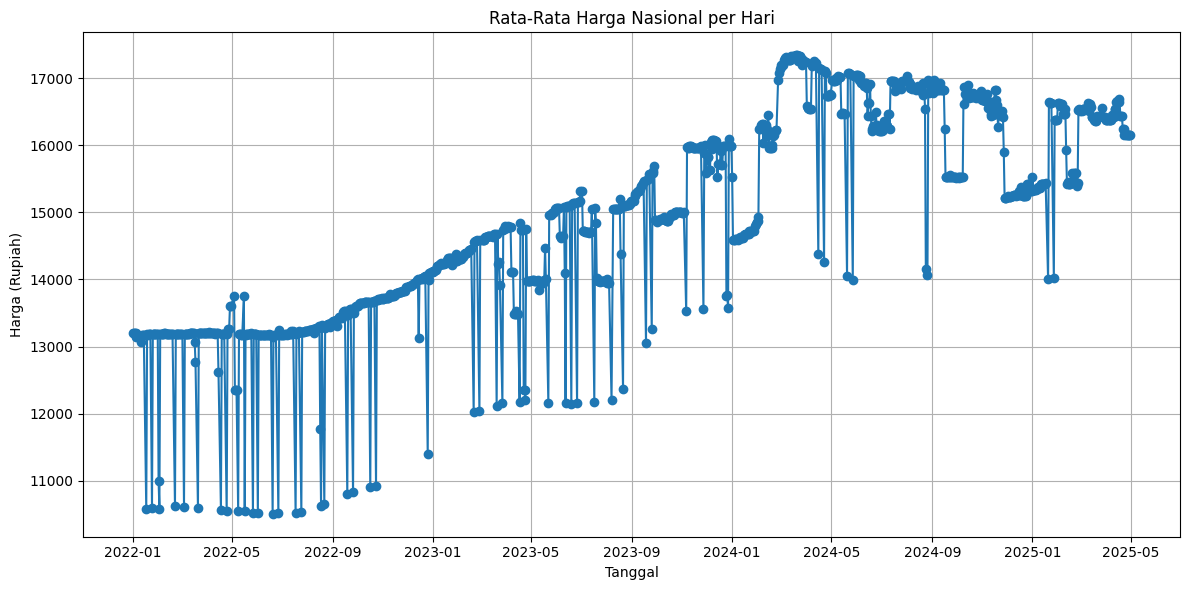

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Baca file CSV
df = pd.read_csv("rata_rata_harga_april_2025.csv")

# Bersihkan kolom harga
df["Rata-rata Harga"] = df["Rata-rata Harga"].str.replace("Rp", "").str.replace(".", "").str.strip()
df["Rata-rata Harga"] = df["Rata-rata Harga"].astype(float)

# Konversi kolom tanggal
df["Tanggal"] = pd.to_datetime(df["Tanggal"], format="%Y/%m/%d")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df["Tanggal"], df["Rata-rata Harga"], marker='o')
plt.title("Rata-Rata Harga Nasional per Hari")
plt.xlabel("Tanggal")
plt.ylabel("Harga (Rupiah)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df.shape

(1120, 2)

In [ ]:
print(df.tail())

        Tanggal  Rata-rata Harga
1115 2025-04-26          16159.0
1116 2025-04-27          16159.0
1117 2025-04-28          16150.0
1118 2025-04-29          16155.0
1119 2025-04-30          16159.0


### EDA Process

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Tanggal          1120 non-null   datetime64[ns]
 1   Rata-rata Harga  1120 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.6 KB


In [ ]:
df.describe()

,Tanggal,Rata-rata Harga
count,1120,1120.000000
mean,2023-09-12 17:38:08.571428608,14913.694643
min,2022-01-01 00:00:00,10505.000000
25%,2022-11-13 18:00:00,13659.000000
50%,2023-09-21 12:00:00,14963.500000
75%,2024-07-16 06:00:00,16379.750000
max,2025-04-30 00:00:00,17345.000000
std,NaN,1518.833223


In [ ]:
df.isnull().sum()

,0
Tanggal,0
Rata-rata Harga,0


In [ ]:
df.duplicated().sum()

np.int64(0)

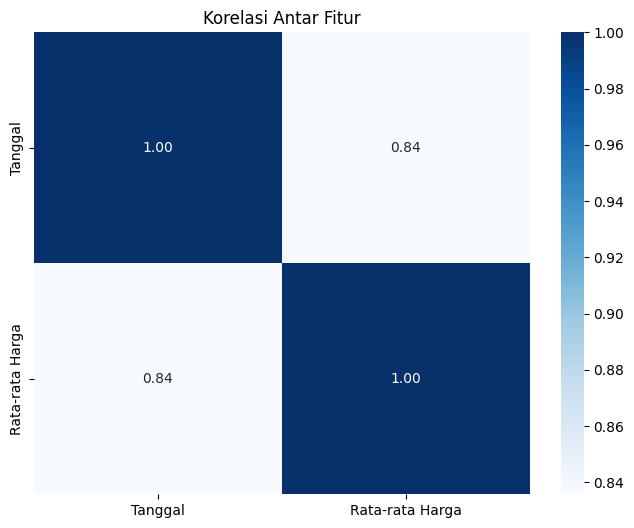

In [ ]:
correlation_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Korelasi Antar Fitur")
plt.show()

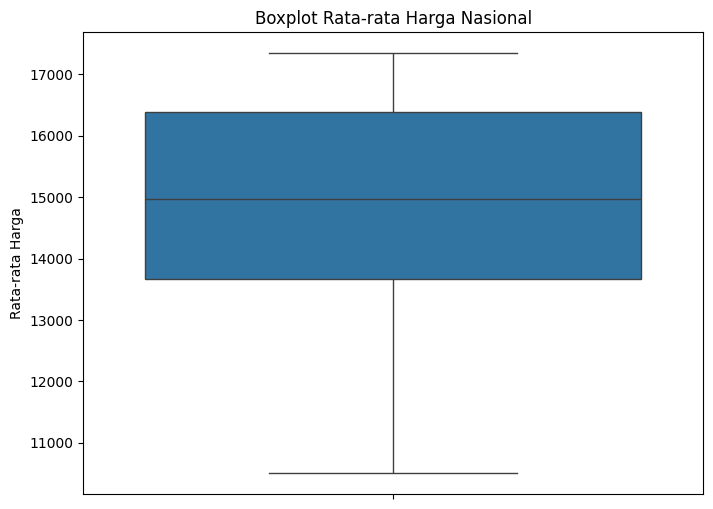

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['Rata-rata Harga'])
plt.title("Boxplot Rata-rata Harga Nasional")
plt.show()

### Scalling Data

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['Rata-rata Harga']])

data_scaled

array([[0.39532164],
       [0.39532164],
       [0.39473684],
       ...,
       [0.8252924 ],
       [0.82602339],
       [0.82660819]])

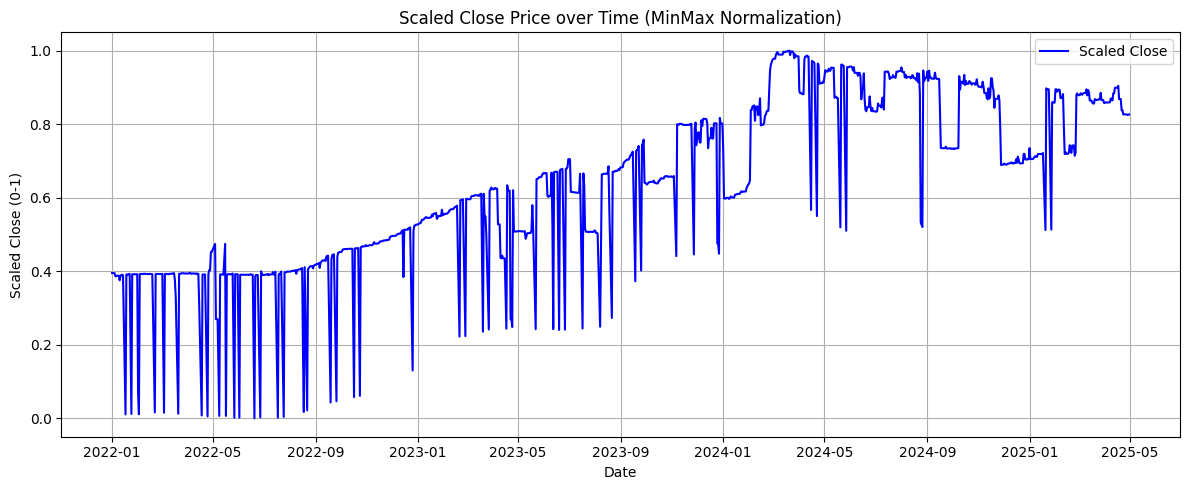

In [ ]:
dates = pd.to_datetime(df['Tanggal'])
close_scaled = data_scaled[:,0]

plt.figure(figsize=(12, 5))
plt.plot(dates, close_scaled, color='blue', label='Scaled Close')
plt.title("Scaled Close Price over Time (MinMax Normalization)")
plt.xlabel("Date")
plt.ylabel("Scaled Close (0-1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Modelling

#### Modelling ML - Random Forest

In [ ]:
def create_ml_window(series, n_past=24):
    X, y = [], []
    for i in range(n_past, len(series)):
        X.append(series[i - n_past:i])
        y.append(series[i])
    return np.array(X), np.array(y)

In [ ]:
close_scaled = data_scaled[:, 0]


X_ml, y_ml = create_ml_window(close_scaled, n_past=24)

split_index = int(len(X_ml) * 0.5)
X_train_ml, X_valid_ml = X_ml[:split_index], X_ml[split_index:]
y_train_ml, y_valid_ml = y_ml[:split_index], y_ml[split_index:]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train_ml, y_train_ml)

RandomForestRegressor(max_depth=10, random_state=42)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_rf = rf_model.predict(X_valid_ml)

mae_rf = mean_absolute_error(y_valid_ml, y_pred_rf)
mse_rf = mean_squared_error(y_valid_ml, y_pred_rf)

print(f"MAE Random Forest: {mae_rf:.4f}")
print(f"MSE Random Forest: {mse_rf:.4f}")

MAE Random Forest: 0.1723
MSE Random Forest: 0.0400


#### Modelling Neural Network

In [ ]:
N_FEATURES = data_scaled.shape[1]
SPLIT_TIME = int(len(data_scaled) * 0.5)
print(f"Jumlah fitur: {N_FEATURES}")
print(f"Split time: {SPLIT_TIME}")

x_train, x_valid = data_scaled[:SPLIT_TIME], data_scaled[SPLIT_TIME:]

Jumlah fitur: 1
Split time: 560


In [ ]:
def windowed_dataset(series, batch_size, n_past=24, n_future=24, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
BATCH_SIZE = 32
N_PAST = 24
N_FUTURE = 24
SHIFT = 1

train_set = windowed_dataset(x_train, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT)
valid_set = windowed_dataset(x_valid, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape=(N_PAST, N_FEATURES)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(N_FEATURES)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < 0.05 and logs.get('val_mae') < 0.05:
            self.model.stop_training = True

callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])

In [ ]:
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=100,
                    callbacks=[callbacks],
                    verbose=1)

Epoch 1/100
     17/Unknown 1s 7ms/step - loss: 0.3340 - mae: 0.3340

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.3314 - mae: 0.3314 - val_loss: 0.1530 - val_mae: 0.1530
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0988 - mae: 0.0988 - val_loss: 0.1391 - val_mae: 0.1391
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0773 - mae: 0.0773 - val_loss: 0.0967 - val_mae: 0.0967
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1046 - mae: 0.1046 - val_loss: 0.1258 - val_mae: 0.1258
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0812 - mae: 0.0812 - val_loss: 0.0953 - val_mae: 0.0953
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1025 - mae: 0.1025 - val_loss: 0.1222 - val_mae: 0.1222
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0756 - mae: 0.0756 - val_loss: 0.0931 - val_mae: 0.0931
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1025 - mae: 0.1025 - val_loss: 0.1216 - val_mae: 0.1216
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0714 -

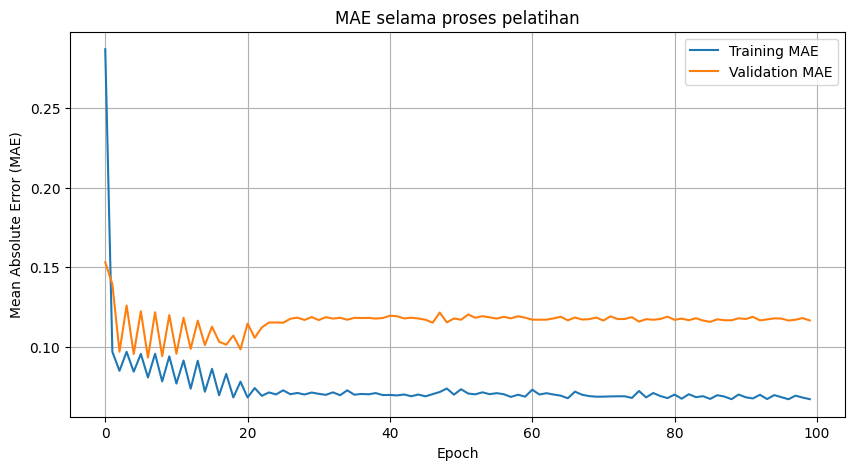

In [ ]:
import matplotlib.pyplot as plt

# Ambil nilai MAE dan val_MAE dari history
mae = history.history['mae']
val_mae = history.history['val_mae']

# Buat plot
plt.figure(figsize=(10, 5))
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE selama proses pelatihan')
plt.legend()
plt.grid(True)
plt.show()

### Prediction

In [ ]:
N_TOTAL_PREDICTION = 240
N_PRED_STEP = N_FUTURE

current_window = df[['Rata-rata Harga']].values[-N_PAST:]
forecast_scaled = []

for _ in range(0, N_TOTAL_PREDICTION, N_PRED_STEP):
    input_scaled = scaler.transform(current_window)
    input_batch = np.expand_dims(input_scaled, axis=0)

    prediction = model.predict(input_batch)[0]
    forecast_scaled.extend(prediction)

    prediction_real = scaler.inverse_transform(prediction)
    current_window = np.vstack([current_window, prediction_real])[-N_PAST:]

forecast_scaled = np.array(forecast_scaled)[:N_TOTAL_PREDICTION]
forecast_real = scaler.inverse_transform(forecast_scaled)

last_date = pd.to_datetime(df['Tanggal'].iloc[-1])
future_dates = [last_date + timedelta(days=i+1) for i in range(N_TOTAL_PREDICTION)]

forecast_df = pd.DataFrame(forecast_real, columns=['Rata-rata Harga'])
forecast_df['Tanggal'] = future_dates

forecast_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,Rata-rata Harga,Tanggal
0,16751.675781,2025-05-01
1,16822.933594,2025-05-02
2,16818.742188,2025-05-03
3,16788.351562,2025-05-04
4,16923.533203,2025-05-05


In [ ]:
import joblib

# Simpan model (jika Keras, jangan pakai joblib)
model.save('model_lstm.keras')

# Simpan scaler
joblib.dump(scaler, 'scaler.joblib')

# Simpan parameter dan input terakhir
params = {
    'N_PAST': N_PAST,
    'N_FUTURE': N_FUTURE,
    'N_TOTAL_PREDICTION': N_TOTAL_PREDICTION,
    'last_window': current_window,
    'last_date': df['Tanggal'].iloc[-1]
}
joblib.dump(params, 'lstm_params.joblib')

['lstm_params.joblib']

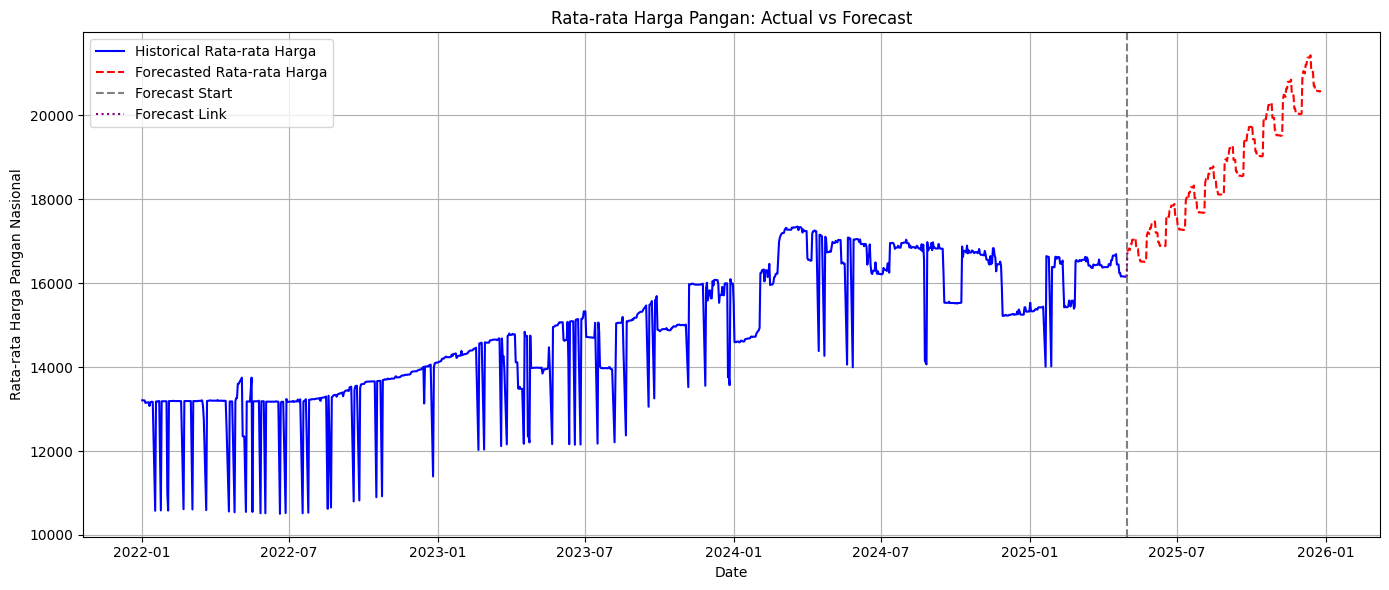

In [ ]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
forecast_df['Tanggal'] = pd.to_datetime(forecast_df['Tanggal'])

plt.figure(figsize=(14, 6))

plt.plot(df['Tanggal'], df['Rata-rata Harga'], label='Historical Rata-rata Harga', color='blue')

plt.plot(forecast_df['Tanggal'], forecast_df['Rata-rata Harga'], label='Forecasted Rata-rata Harga', color='red', linestyle='dashed')

plt.axvline(x=df['Tanggal'].iloc[-1], color='gray', linestyle='--', label='Forecast Start')

plt.plot(
    [df['Tanggal'].iloc[-1], forecast_df['Tanggal'].iloc[0]],
    [df['Rata-rata Harga'].iloc[-1], forecast_df['Rata-rata Harga'].iloc[0]],
    color='purple', linestyle=':', label='Forecast Link'
)

plt.title("Rata-rata Harga Pangan: Actual vs Forecast")
plt.xlabel("Date")
plt.ylabel("Rata-rata Harga Pangan Nasional")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Hitung perubahan harga dari awal ke akhir
start_price = forecast_df['Rata-rata Harga'].iloc[0]
end_price = forecast_df['Rata-rata Harga'].iloc[-1]
price_change = end_price - start_price
price_change_pct = (price_change / start_price) * 100

# Tentukan arah tren
if price_change > 0:
    trend = "kenaikan"
elif price_change < 0:
    trend = "penurunan"
else:
    trend = "harga tetap stabil"

# Cari tanggal dengan perubahan terbesar (opsional, bisa dihitung delta harian)
forecast_df['Delta'] = forecast_df['Rata-rata Harga'].diff()
max_delta_date = forecast_df.loc[forecast_df['Delta'].abs().idxmax(), 'Tanggal']
max_delta_value = forecast_df['Delta'].abs().max()

# Buat kalimat kesimpulan
summary_sentence = (
    f"Berdasarkan hasil prediksi model, harga beras menunjukkan tren {trend} "
    f"selama {len(forecast_df)} hari ke depan, dari Rp{start_price:,.0f} "
    f"menjadi Rp{end_price:,.0f}, atau perubahan sekitar {price_change_pct:.2f}%. "
    f"Perubahan paling signifikan terjadi pada {max_delta_date.date()} "
    f"dengan selisih sekitar Rp{max_delta_value:,.0f}."
)

print(summary_sentence)

Berdasarkan hasil prediksi model, harga beras menunjukkan tren kenaikan selama 240 hari ke depan, dari Rp16,752 menjadi Rp20,578, atau perubahan sekitar 22.84%. Perubahan paling signifikan terjadi pada 2025-12-03 dengan selisih sekitar Rp903.
